#### Завдання №1.1

In [1]:
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

In [2]:
class FirstNumberGenerator:
    def __init__(self, lam: float):
        self.lam = lam

    def rand_number(self) -> float:
        number = 0.0
        while number == 0.0:
            number = random.random()

        return (-1.0 / self.lam) * math.log(number)
    
    def calc_distribution(self, x: float) -> float:
        return 1 - math.exp(-self.lam * x)
    

class SecondNumberGenerator:
    def __init__(self, alpha: float, sigma: float):
        self.alpha = alpha
        self.sigma = sigma

    def __get_rand_number(self):
        number = 0.0
        while number == 0.0:
            number = random.random()

        return number

    def rand_number(self) -> float:
        nm = sum([self.__get_rand_number() for _ in range(1, 13)]) - 6
        return self.sigma * nm + self.alpha
    
    def calc_distribution(self, x: float) -> float:
        return 0.5 * (1 + math.erf((x - self.alpha)/(math.sqrt(2) * self.sigma)))
    

class ThirdNumberGenerator:
    def __init__(self, a: float, c: float):
        self.a = a
        self.c = c

        number = 0.0
        while number == 0.0:
            number = random.random()

        self.z = number

    def rand_number(self) -> float:
        self.z = math.fmod(self.a * self.z, self.c)
        return self.z / self.c
    
    def calc_distribution(self, x: float) -> float:
        if x < 0:
            return 0
        elif x > 1:
            return 1
        else:
            return x

In [3]:
gen = FirstNumberGenerator(1.0)
gen.rand_number()

2.11063314110047

In [4]:
gen = SecondNumberGenerator(1, 2)
gen.rand_number()

4.589542957513112

In [5]:
gen = ThirdNumberGenerator(math.pow(5, 13), math.pow(2, 31))
gen.rand_number()

0.3510760406802262

Для перевірки на відповідність відповідному розподілу буде виконано:

1. Згенеровано вибірку

2. Розбито дані на інтервали довжини: ```h = (Xmax - Xmin)/k, k = 20 if (n > 100)```

3. Обчислено очікувані частоти

4. Обчислено X2: ```X2 = Sum(math.pow(ni - n*pt, 2)/(n*pt))```, критерій X2 вимагає, щоб кількість влучень у кожний інтервал була не менша 5

5. Порівняно  з табличним значенням критерію X2 кр, яке взяте при рівні значимості α=0,05 та кількості степенів свободи, рівній кількості інтервалів у гістограмі частот k мінус 1 мінус кількість параметрів закону розподілу. 


In [17]:
def get_base_intervals(data: list[float]):
    data.sort()

    k = 20
    x_min = min(data)
    x_max = max(data)
    h = (x_max - x_min) / k

    intervals = [[x_min + h*x, x_min + h*(x+1)] for x in range(0, k)]

    intervals = pd.DataFrame({'Xi-1, Xi': intervals})
    intervals['ni'] = 0
    intervals['data'] = intervals['data'] = [[] for _ in range(len(intervals))]

    for i in data:
        for j in range(len(intervals)):

            left = intervals['Xi-1, Xi'][j][0]
            right = intervals['Xi-1, Xi'][j][1]

            if left <= i < right:
                intervals.at[j, 'ni'] += 1
                intervals.at[j, 'data'].append(i)
                break

            if j == len(intervals) - 1 and i >= right:
                intervals.at[j, 'ni'] += 1
                intervals.at[j, 'data'].append(i)
                break

    return intervals


def add_theoretical_intervals(intervals, gen):
    intervals['ni_t'] = 0
    intervals['p_t'] = 0.0

    elem_count = intervals['ni'].sum()

    for i in range(len(intervals)):
        left = intervals['Xi-1, Xi'][i][0]
        right = intervals['Xi-1, Xi'][i][1]

        p_t = gen.calc_distribution(right) - gen.calc_distribution(left)
        ni_t = math.ceil(elem_count * p_t)

        intervals.at[i, 'ni_t'] = ni_t
        intervals.at[i, 'p_t'] = p_t

    return intervals


def fix_intervals(intervals):
    fixed_intervals = intervals.copy()

    for i in range(len(fixed_intervals)):
        if fixed_intervals['ni'][i] < 5 or fixed_intervals['ni_t'][i] < 5:

            if i < len(fixed_intervals) - 1:
                fixed_intervals.at[i, 'Xi-1, Xi'] = [
                    fixed_intervals['Xi-1, Xi'][i][0],
                    fixed_intervals['Xi-1, Xi'][i + 1][1]
                ]

                fixed_intervals.at[i, 'data'] = fixed_intervals['data'][i] + fixed_intervals['data'][i+1]

                fixed_intervals.at[i, 'ni'] += fixed_intervals['ni'][i + 1]
                fixed_intervals.at[i, 'ni_t'] += fixed_intervals['ni_t'][i + 1]
                fixed_intervals.at[i, 'p_t'] += fixed_intervals['p_t'][i + 1]

                fixed_intervals = fixed_intervals.drop(i + 1).reset_index(drop=True)
                return fix_intervals(fixed_intervals)
            elif i != 0:
                fixed_intervals.at[i, 'Xi-1, Xi'] = [
                    fixed_intervals['Xi-1, Xi'][i - 1][0],
                    fixed_intervals['Xi-1, Xi'][i][1]
                ]

                fixed_intervals.at[i - 1, 'data'] = fixed_intervals['data'][i - 1] + fixed_intervals['data'][i]

                fixed_intervals.at[i - 1, 'ni'] += fixed_intervals['ni'][i]
                fixed_intervals.at[i - 1, 'ni_t'] += fixed_intervals['ni_t'][i]
                fixed_intervals.at[i - 1, 'p_t'] += fixed_intervals['p_t'][i]

                fixed_intervals = fixed_intervals.drop(i).reset_index(drop=True)
                return fix_intervals(fixed_intervals)

    return fixed_intervals


def calc_x2(intervals) -> float:
    x2 = 0.0
    eps = 1e-12

    for i in range(len(intervals)):
        ni = intervals['ni'][i]
        ni_t = intervals['ni_t'][i]

        x2 += math.pow((ni - ni_t), 2) / (ni_t if ni_t != 0 else eps)

    return x2


def average(numbers: list[float]) -> float:
    return sum(numbers) / len(numbers)

def variance(numbers: list[float]) -> float:
    avg = average(numbers)
    return sum([math.pow(x - avg, 2) for x in numbers]) / len(numbers)


def hist(data, title: str, text_arr: list[str], bins = 100 ):   
    plt.hist(data, 
             bins=bins, 
             alpha=0.6, 
             label='data',
             edgecolor="black")
    
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("count")
    plt.legend()
    plt.grid(True)
    plt.show()

    for text in text_arr:
        print(text)

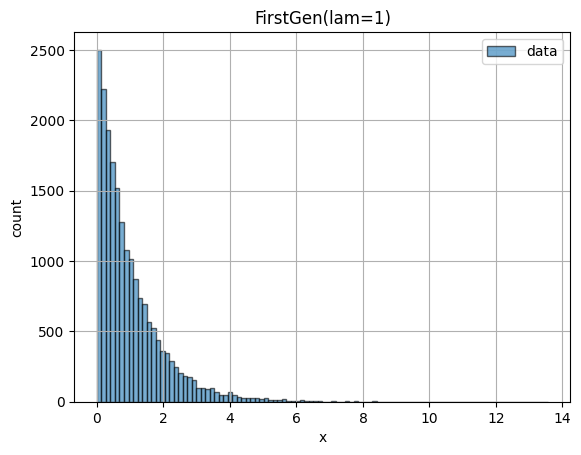

chi2=27.58711163827534, calc_chi2=8.546874832900455
average=0.9975513923401382
variance=1.0025307193107063


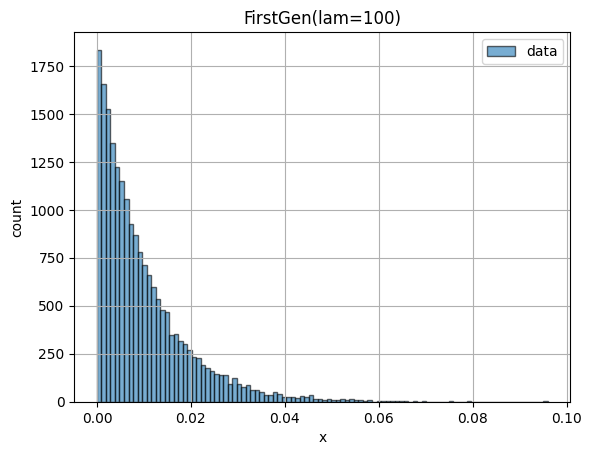

chi2=27.58711163827534, calc_chi2=20.042973255317257
average=0.009907989761422854
variance=9.696377398585109e-05


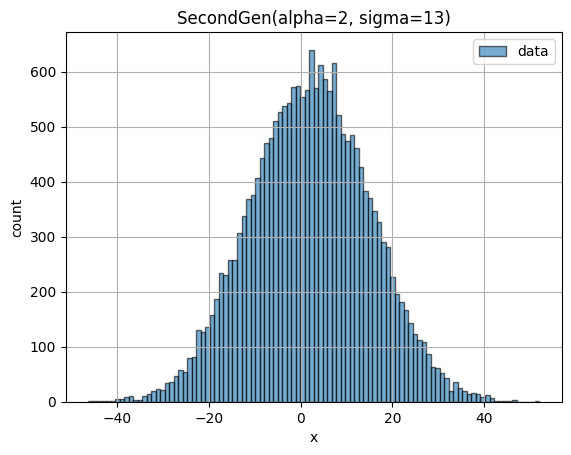

chi2=27.58711163827534, calc_chi2=25.78324619968753
average=2.0554139396001383
variance=168.0265597763952


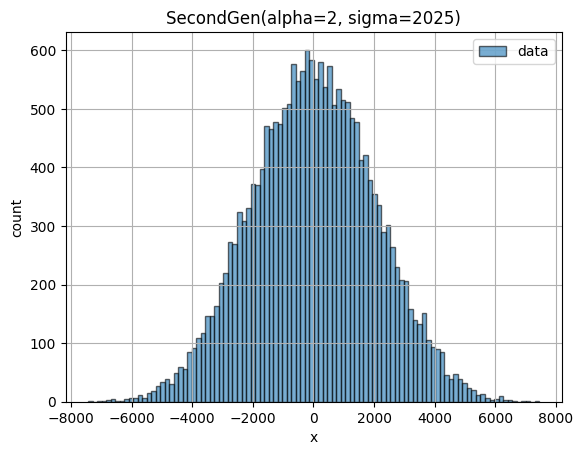

chi2=27.58711163827534, calc_chi2=28.64710510608552
average=-0.3932544901433561
variance=4143755.243343736


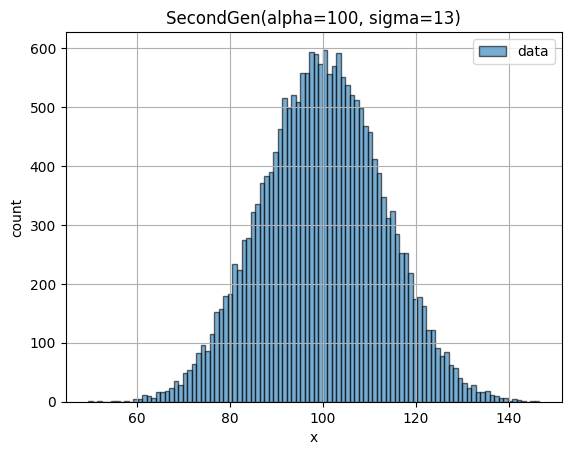

chi2=27.58711163827534, calc_chi2=26.55712276323253
average=99.89854970074383
variance=169.58599429219657


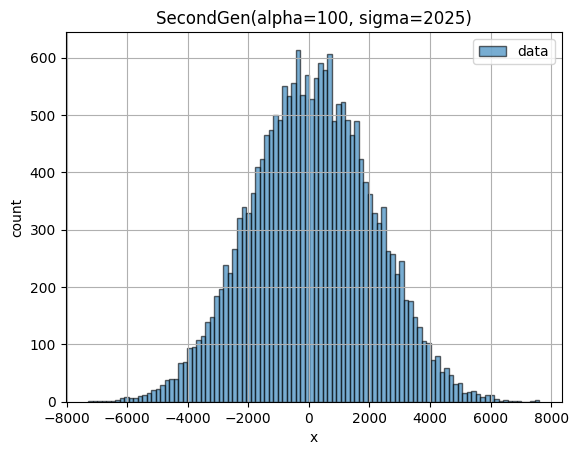

chi2=27.58711163827534, calc_chi2=26.864480402394317
average=95.17611164544414
variance=4079533.1873613037


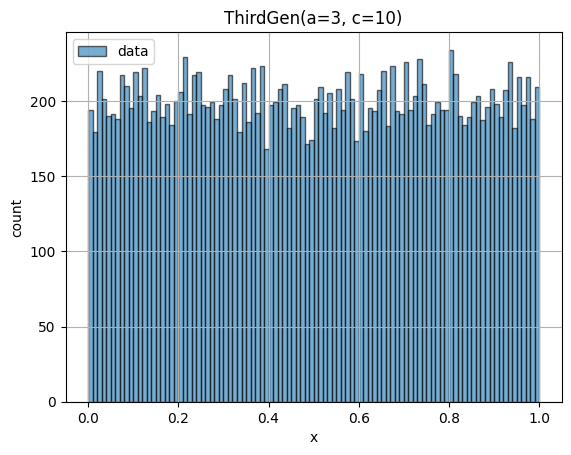

chi2=27.58711163827534, calc_chi2=18.176
average=0.5004658923849866
variance=0.0836877371804836


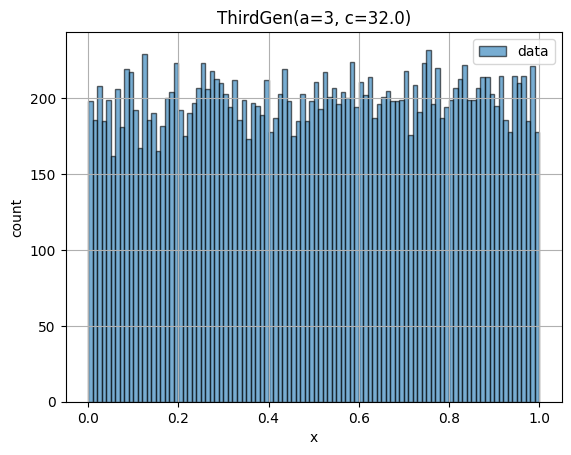

chi2=27.58711163827534, calc_chi2=19.093999999999998
average=0.5044279816972247
variance=0.0829394322593662


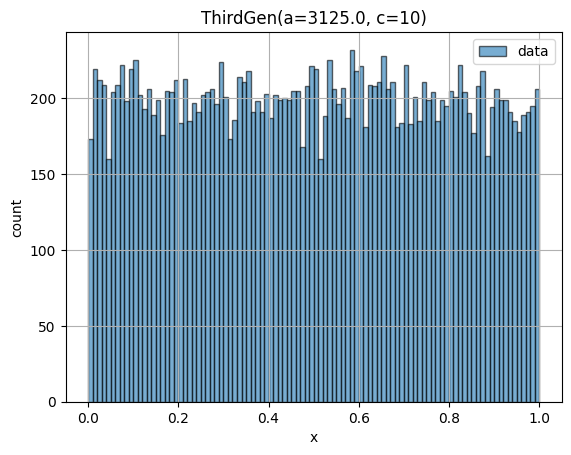

chi2=27.58711163827534, calc_chi2=13.219999999999999
average=0.49795346611429914
variance=0.08264947198289907


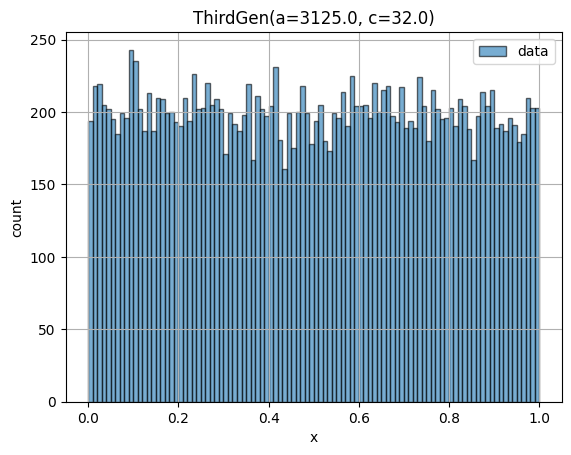

chi2=27.58711163827534, calc_chi2=16.851999999999997
average=0.49685108031606406
variance=0.0836377235978601


In [16]:
def test_generators():
    chi2 = stats.chi2.ppf(1 - 0.05, 20 - 3)
    num_elems = 20_000

    lambdas = [1, 100]
    for lam in lambdas:
        gen = FirstNumberGenerator(lam)
        data = [gen.rand_number() for _ in range(num_elems)]

        intervals = get_base_intervals(data)
        intervals = add_theoretical_intervals(intervals, gen)
        intervals = fix_intervals(intervals)

        calc_chi2 = calc_x2(intervals)

        hist(data, 'FirstGen(lam={lam})'.format(lam=lam), [
            "chi2={chi2}, calc_chi2={calc_chi2}".format(chi2=chi2, calc_chi2=calc_chi2),
            "average={average}".format(average=average(data)),
            "variance={variance}".format(variance=variance(data)),
        ])

    alphas = [2, 100]
    sigmas = [13, 2025]
    for alpha in alphas:
        for sigma in sigmas:
            gen = SecondNumberGenerator(alpha, sigma)
            data = [gen.rand_number() for _ in range(num_elems)]

            intervals = get_base_intervals(data)
            intervals = add_theoretical_intervals(intervals, gen)
            intervals = fix_intervals(intervals)

            calc_chi2 = calc_x2(intervals)

            hist(data, 'SecondGen(alpha={alpha}, sigma={sigma})'.format(alpha=alpha, sigma=sigma), [
                "chi2={chi2}, calc_chi2={calc_chi2}".format(chi2=chi2, calc_chi2=calc_chi2),
                "average={average}".format(average=average(data)),
                "variance={variance}".format(variance=variance(data)),
            ])

    aa = [3, math.pow(5, 5)]
    cc = [10, math.pow(2, 5)]
    for a in aa:
        for c in cc:
            gen = ThirdNumberGenerator(a, c)
            data = [gen.rand_number() for _ in range(num_elems)]

            intervals = get_base_intervals(data)
            intervals = add_theoretical_intervals(intervals, gen)
            intervals = fix_intervals(intervals)

            calc_chi2 = calc_x2(intervals)

            hist(data, 'ThirdGen(a={a}, c={c})'.format(a=a, c=c), [
                "chi2={chi2}, calc_chi2={calc_chi2}".format(chi2=chi2, calc_chi2=calc_chi2),
                "average={average}".format(average=average(data)),
                "variance={variance}".format(variance=variance(data)),
            ])

test_generators()

#### Завдання на додаткові бали

Дослідити закон розподілу часової затримки програми на виконання методу сортування колекції 1_000_000 обʼєктів.

In [ ]:
import numpy as np
from scipy import stats
import os
import pandas as pd

#### Зчитування даних

In [52]:
times1 = []
times2 = []

file_path = r'C:\Users\vladi\.vscode\Git\SM_25\SM_25\lab1\sort_collection\sort_times1.txt'
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        times1 = [float(line.strip()) for line in file]
else:
    print(f"File not found: {file_path}")

file_path = r'C:\Users\vladi\.vscode\Git\SM_25\SM_25\lab1\sort_collection\sort_times2.txt'
if os.path.exists(file_path):
    with open(file_path, 'r') as file:
        times2 = [float(line.strip()) for line in file]
else:
    print(f"File not found: {file_path}")

In [53]:
data1 = np.sort(np.array(times1))
data2 = np.sort(np.array(times2))

In [54]:
s1 = pd.Series(data1)
print(s1.describe())
print("-" * 30)

s2 = pd.Series(data2)
print(s2.describe())
print("-" * 30)

count    10000.000000
mean        67.161672
std          4.942565
min         56.269800
25%         64.999600
50%         66.280650
75%         68.099400
max        126.565900
dtype: float64
------------------------------
count    10000.000000
mean       574.240604
std         27.129240
min        519.011900
25%        560.909700
50%        568.258250
75%        578.464950
max        955.074600
dtype: float64
------------------------------


#### Дослідження розподілу

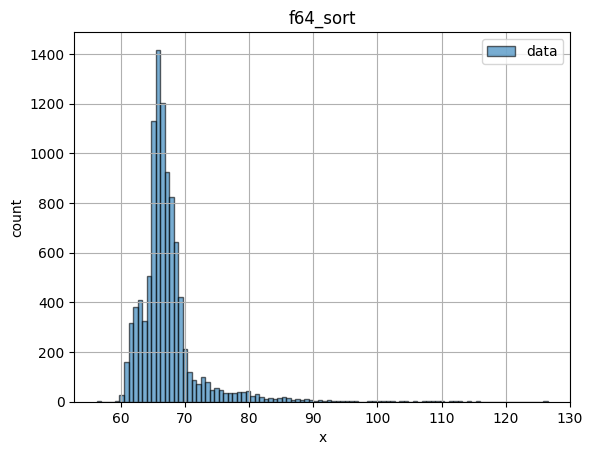

In [24]:
hist(s1, "f64_sort", [], 100)

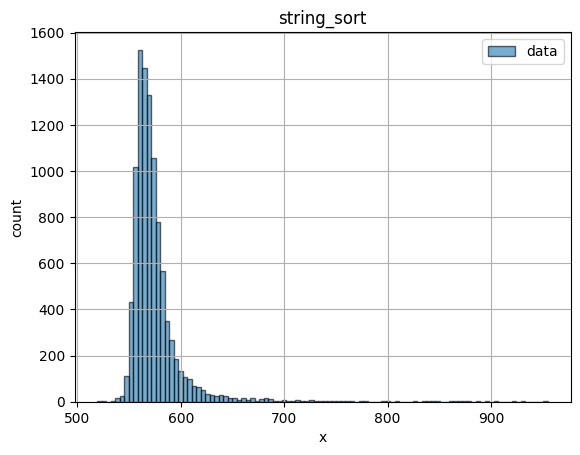

In [25]:
hist(s2, "string_sort", [], 100)

In [69]:
x = np.linspace(min(data1), max(data1), 500)

In [70]:
a, loc_g, scale_g = stats.gamma.fit(data1)
pdf_gamma = stats.gamma.pdf(x, a, loc=loc_g, scale=scale_g)

shape, loc_l, scale_l = stats.lognorm.fit(data1)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc=loc_l, scale=scale_l)

In [71]:
ks_statistic, ks_p_value = stats.kstest(data1, "lognorm", args=(shape, loc_l, scale_l))
ks_p_value

np.float64(5.580527494942959e-88)

In [72]:
ks_statistic, ks_p_value = stats.kstest(data1, "gamma", args=(a, loc_g, scale_g))
ks_p_value

np.float64(8.493351258112373e-138)

In [73]:
a, loc_g, scale_g = stats.gamma.fit(data2)
pdf_gamma = stats.gamma.pdf(x, a, loc=loc_g, scale=scale_g)

shape, loc_l, scale_l = stats.lognorm.fit(data2)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc=loc_l, scale=scale_l)

In [74]:
ks_statistic, ks_p_value = stats.kstest(data2, "lognorm", args=(shape, loc_l, scale_l))
ks_p_value

np.float64(3.0066847910172455e-69)

In [75]:
ks_statistic, ks_p_value = stats.kstest(data2, "gamma", args=(a, loc_g, scale_g))
ks_p_value

np.float64(1.6423060540874296e-131)